<a href="https://colab.research.google.com/github/fedassembly/tensorflow-cert-prep/blob/main/05_Transfer_Learning_in_TensorFlow_Part_2_Fine_tuning_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 5 epochs using [`tf.keras.applications.EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) as the base model. Use the [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save the weights to file.


In [1]:
!rm -rf /content/10_food_classes_10_percent.zip /content/10_food_classes_10_percent /content/__MACOSX
!wget -q -P /content https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
!unzip -q 10_food_classes_10_percent.zip -d /content
!rm -rf /content/__MACOSX

In [2]:
import os
from pathlib import Path

DATA_DIR = "10_food_classes_10_percent/"
TRAIN_DIR = DATA_DIR + "train"
TEST_DIR = DATA_DIR + "test"
class_names = os.listdir(TRAIN_DIR)

class_counts = {"train": dict.fromkeys(class_names, 0), "test": dict.fromkeys(class_names, 0)}
for i in Path(DATA_DIR).glob("**/*.jp*g"):
  class_counts[i.parent.parent.name][i.parent.name] += 1
class_counts

{'train': {'sushi': 75,
  'hamburger': 75,
  'ramen': 75,
  'grilled_salmon': 75,
  'pizza': 75,
  'ice_cream': 75,
  'fried_rice': 75,
  'chicken_wings': 75,
  'steak': 75,
  'chicken_curry': 75},
 'test': {'sushi': 250,
  'hamburger': 250,
  'ramen': 250,
  'grilled_salmon': 250,
  'pizza': 250,
  'ice_cream': 250,
  'fried_rice': 250,
  'chicken_wings': 250,
  'steak': 250,
  'chicken_curry': 250}}

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

def create_model(name, augment = False):
  data_augmentation = keras.Sequential([
      keras.layers.RandomFlip(),
      keras.layers.RandomHeight(0.2),
      keras.layers.RandomWidth(0.2),
      keras.layers.RandomRotation(0.2),
      keras.layers.RandomZoom(0.2, 0.2),
      keras.layers.RandomBrightness(0.2),
      keras.layers.Resizing(224, 224),
  ], name="data_augmentation")
  # EfficientNet models expect their inputs to be float tensors of pixels with
  # values in the [0-255] range.
  base_model = keras.applications.EfficientNetB0(
      include_top=False,
      weights="imagenet",
  )
  base_model.trainable = False # affects weights and biases
  feature_extractor = keras.layers.GlobalAvgPool2D(name="feature_extraction")
  top_layer = keras.layers.Dense(10, activation="softmax", name="outputs")
  inputs = keras.Input(shape=(224, 224, 3), name="inputs")
  if augment:
    x = data_augmentation(inputs)
    x = base_model(x, training=False) # affects batch norm stats
  else:
    x = base_model(inputs, training=False)
  x = feature_extractor(x)
  outputs = top_layer(x)
  model = keras.Model(inputs, outputs, name=name)
  return model

In [4]:
model_0 = create_model("model_0", augment=False)
print("Layers of model_0:", [layer.name for layer in model_0.layers])
print("Last 10 layers of efficientnetb0 'layer' in model_0 and whether they're trainable:",
 [(i, layer.name, layer.trainable) for i, layer in enumerate(model_0.layers[1].layers)][-10:])

16705208/16705208 [==============================] - 2s 0us/step
Layers of model_0: ['inputs', 'efficientnetb0', 'feature_extraction', 'outputs']
Last 10 layers of efficientnetb0 'layer' in model_0 and whether they're trainable: [(228, 'block7a_se_squeeze', False), (229, 'block7a_se_reshape', False), (230, 'block7a_se_reduce', False), (231, 'block7a_se_expand', False), (232, 'block7a_se_excite', False), (233, 'block7a_project_conv', False), (234, 'block7a_project_bn', False), (235, 'top_conv', False), (236, 'top_bn', False), (237, 'top_activation', False)]


In [5]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="categorical",
    class_names=class_names,
    image_size=(224, 224),
    subset="both",
    validation_split=0.2,
    seed=42
)
test_ds = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    label_mode="categorical",
    class_names=class_names,
    image_size=(224, 224),
)

Found 750 files belonging to 10 classes.
Using 600 files for training.
Using 150 files for validation.
Found 2500 files belonging to 10 classes.


In [6]:
model_1 = create_model("model_1", augment=True)
print("Layers of model_1:", [layer.name for layer in model_1.layers])

Layers of model_1: ['inputs', 'data_augmentation', 'efficientnetb0', 'feature_extraction', 'outputs']


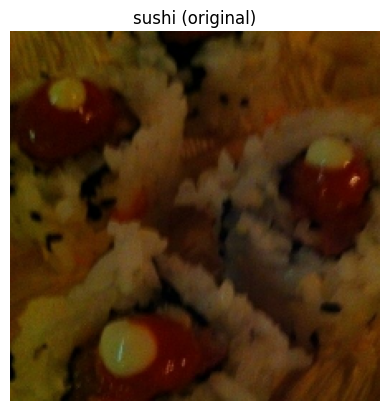

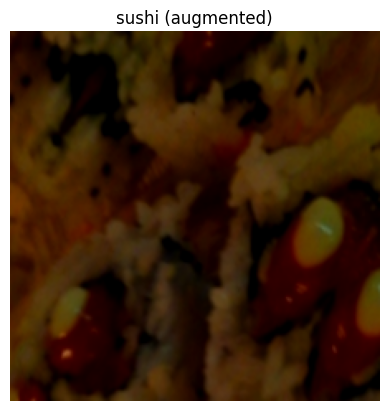

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import random

for images, labels in train_ds.take(1):
  random_idx = random.choice(range(len(images)))
  random_image = images[random_idx]
  random_image_aug = model_1.layers[1](random_image)
  class_label = class_names[labels[random_idx].numpy().argmax()]
  plt.imshow(random_image.numpy().astype("uint8"))
  plt.title(class_label + " (original)")
  plt.axis("off")
  plt.figure()
  plt.imshow(random_image_aug.numpy().astype("uint8"))
  plt.title(class_label + " (augmented)")
  plt.axis("off")

In [8]:
tf.random.set_seed(42)
model_0.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.AdamW(),
                metrics=["accuracy"])
results = model_0.evaluate(train_ds)
print("Loss: {:0.4f}".format(results[0]))
print("Expected loss @ init: {:0.4f}".format(np.log(len(class_names))))

19/19 [==============================] - 13s 109ms/step - loss: 2.3734 - accuracy: 0.0967
Loss: 2.3734
Expected loss @ init: 2.3026


In [9]:
tf.random.set_seed(42)

def save_checkpoint(model_name: str) -> None:
  return keras.callbacks.ModelCheckpoint(
    f"./checkpoints/{model_name}/cp.ckpt",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True
    )

model_0.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])
history = model_0.fit(train_ds,
                      epochs=5,
                      validation_data=val_ds,
                      callbacks=[save_checkpoint(model_0.name)])

Epoch 1/5
19/19 [==============================] - 12s 262ms/step - loss: 1.9373 - accuracy: 0.3767 - val_loss: 1.6123 - val_accuracy: 0.5867
Epoch 2/5
19/19 [==============================] - 3s 110ms/step - loss: 1.1839 - accuracy: 0.7533 - val_loss: 1.1523 - val_accuracy: 0.7067
Epoch 3/5
19/19 [==============================] - 2s 107ms/step - loss: 0.8350 - accuracy: 0.8350 - val_loss: 0.9447 - val_accuracy: 0.7400
Epoch 4/5
19/19 [==============================] - 3s 133ms/step - loss: 0.6633 - accuracy: 0.8750 - val_loss: 0.8381 - val_accuracy: 0.7533
Epoch 5/5
19/19 [==============================] - 3s 115ms/step - loss: 0.5528 - accuracy: 0.8867 - val_loss: 0.7641 - val_accuracy: 0.8000


In [10]:
model_0.evaluate(test_ds)

79/79 [==============================] - 6s 74ms/step - loss: 0.6136 - accuracy: 0.8516


[0.6136056780815125, 0.8515999913215637]

In [11]:
model_0_copy = create_model("model_0_copy", augment=False)
model_0_copy.compile(loss="categorical_crossentropy",
                     optimizer=keras.optimizers.Adam(),
                     metrics=["accuracy"])
model_0_copy.load_weights(f"./checkpoints/{model_0.name}/cp.ckpt")
model_0_copy.evaluate(test_ds)

79/79 [==============================] - 10s 71ms/step - loss: 0.6136 - accuracy: 0.8516


[0.6136054992675781, 0.8515999913215637]

In [12]:
model_0_clone = keras.models.clone_model(model_0)
model_0_clone.compile(loss="categorical_crossentropy",
                      optimizer=keras.optimizers.Adam(),
                      metrics=["accuracy"])
model_0_clone.load_weights(f"./checkpoints/{model_0.name}/cp.ckpt")
model_0_clone.evaluate(test_ds)

79/79 [==============================] - 8s 68ms/step - loss: 0.7414 - accuracy: 0.7944


[0.7414203882217407, 0.7943999767303467]

Why `clone_model` behaves differently than `create_model`?

In [13]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])
history = model_1.fit(train_ds,
                      epochs=5,
                      validation_data=val_ds,
                      callbacks=[save_checkpoint(model_1.name)])

Epoch 1/5
19/19 [==============================] - 11s 221ms/step - loss: 2.1248 - accuracy: 0.2633 - val_loss: 1.7047 - val_accuracy: 0.5400
Epoch 2/5
19/19 [==============================] - 3s 111ms/step - loss: 1.5572 - accuracy: 0.5933 - val_loss: 1.3054 - val_accuracy: 0.6467
Epoch 3/5
19/19 [==============================] - 3s 113ms/step - loss: 1.2490 - accuracy: 0.7083 - val_loss: 1.0765 - val_accuracy: 0.6933
Epoch 4/5
19/19 [==============================] - 3s 115ms/step - loss: 1.0487 - accuracy: 0.7283 - val_loss: 0.9435 - val_accuracy: 0.7133
Epoch 5/5
19/19 [==============================] - 3s 139ms/step - loss: 0.9429 - accuracy: 0.7817 - val_loss: 0.8611 - val_accuracy: 0.7400


In [14]:
model_1.evaluate(test_ds)

79/79 [==============================] - 6s 66ms/step - loss: 0.7733 - accuracy: 0.8164


[0.7733113169670105, 0.8163999915122986]

2. Fine-tune the last 20 layers of the base model you trained in 2 for another 5 epochs. How did it go?


In [15]:
model_0_fine = create_model("model_0_fine", augment=False)
model_0_fine.load_weights(f"./checkpoints/{model_0.name}/cp.ckpt")
for layer in model_0_fine.layers[1].layers[-20:]:
  layer.trainable = True
model_0_fine.compile(loss="categorical_crossentropy",
                     optimizer=keras.optimizers.Adam(1e-4),
                     metrics=["accuracy"])
model_0_fine.evaluate(test_ds)

79/79 [==============================] - 8s 66ms/step - loss: 0.6136 - accuracy: 0.8516


[0.6136057376861572, 0.8515999913215637]

In [16]:
print("Last 25 layers of efficientnetb0 'layer' in model_0_fine and whether they're trainable:")
[(i, layer.name, layer.trainable) for i, layer in enumerate(model_0_fine.layers[1].layers)][-25:]

Last 25 layers of efficientnetb0 'layer' in model_0_fine and whether they're trainable:


[(213, 'block6d_se_squeeze', False),
 (214, 'block6d_se_reshape', False),
 (215, 'block6d_se_reduce', False),
 (216, 'block6d_se_expand', False),
 (217, 'block6d_se_excite', False),
 (218, 'block6d_project_conv', True),
 (219, 'block6d_project_bn', True),
 (220, 'block6d_drop', True),
 (221, 'block6d_add', True),
 (222, 'block7a_expand_conv', True),
 (223, 'block7a_expand_bn', True),
 (224, 'block7a_expand_activation', True),
 (225, 'block7a_dwconv', True),
 (226, 'block7a_bn', True),
 (227, 'block7a_activation', True),
 (228, 'block7a_se_squeeze', True),
 (229, 'block7a_se_reshape', True),
 (230, 'block7a_se_reduce', True),
 (231, 'block7a_se_expand', True),
 (232, 'block7a_se_excite', True),
 (233, 'block7a_project_conv', True),
 (234, 'block7a_project_bn', True),
 (235, 'top_conv', True),
 (236, 'top_bn', True),
 (237, 'top_activation', True)]

In [17]:
history = model_0_fine.fit(train_ds,
                           epochs=10,
                           initial_epoch=4,
                           validation_data=val_ds,
                           callbacks=[save_checkpoint(model_0_fine.name)])

Epoch 5/10
19/19 [==============================] - 9s 109ms/step - loss: 0.4823 - accuracy: 0.9033 - val_loss: 0.7187 - val_accuracy: 0.8000
Epoch 6/10
19/19 [==============================] - 2s 111ms/step - loss: 0.4247 - accuracy: 0.9150 - val_loss: 0.6837 - val_accuracy: 0.8000
Epoch 7/10
19/19 [==============================] - 3s 133ms/step - loss: 0.3765 - accuracy: 0.9350 - val_loss: 0.6592 - val_accuracy: 0.8000
Epoch 8/10
19/19 [==============================] - 2s 109ms/step - loss: 0.3382 - accuracy: 0.9400 - val_loss: 0.6343 - val_accuracy: 0.8133
Epoch 9/10
19/19 [==============================] - 2s 108ms/step - loss: 0.3048 - accuracy: 0.9517 - val_loss: 0.6244 - val_accuracy: 0.8067
Epoch 10/10
19/19 [==============================] - 2s 107ms/step - loss: 0.2767 - accuracy: 0.9600 - val_loss: 0.6130 - val_accuracy: 0.7933


In [18]:
model_0_fine.evaluate(test_ds)

79/79 [==============================] - 7s 81ms/step - loss: 0.4679 - accuracy: 0.8736


[0.4679199159145355, 0.8736000061035156]

3. Fine-tune the last 30 layers of the base model you trained in 2 for another 5 epochs. How did it go?


In [19]:
model_0_ultra_fine = create_model("model_0_ultra_fine", augment=False)
model_0_ultra_fine.load_weights(f"./checkpoints/{model_0.name}/cp.ckpt")
for layer in model_0_ultra_fine.layers[1].layers[-30:]:
  layer.trainable = True
model_0_ultra_fine.compile(loss="categorical_crossentropy",
                           optimizer=keras.optimizers.Adam(1e-4),
                           metrics=["accuracy"])
model_0_ultra_fine.fit(train_ds,
                       epochs=10,
                       initial_epoch=4,
                       validation_data=val_ds,
                       callbacks=[save_checkpoint(model_0_ultra_fine.name)]
                       )
model_0_ultra_fine.evaluate(test_ds)

Epoch 5/10
19/19 [==============================] - 11s 187ms/step - loss: 0.4813 - accuracy: 0.9083 - val_loss: 0.7187 - val_accuracy: 0.8000
Epoch 6/10
19/19 [==============================] - 2s 107ms/step - loss: 0.4237 - accuracy: 0.9217 - val_loss: 0.6827 - val_accuracy: 0.8000
Epoch 7/10
19/19 [==============================] - 2s 108ms/step - loss: 0.3772 - accuracy: 0.9283 - val_loss: 0.6585 - val_accuracy: 0.8133
Epoch 8/10
19/19 [==============================] - 3s 139ms/step - loss: 0.3370 - accuracy: 0.9417 - val_loss: 0.6385 - val_accuracy: 0.8067
Epoch 9/10
19/19 [==============================] - 2s 108ms/step - loss: 0.3058 - accuracy: 0.9517 - val_loss: 0.6213 - val_accuracy: 0.8067
Epoch 10/10
79/79 [==============================] - 7s 82ms/step - loss: 0.4678 - accuracy: 0.8732


[0.4677591919898987, 0.873199999332428]

4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.




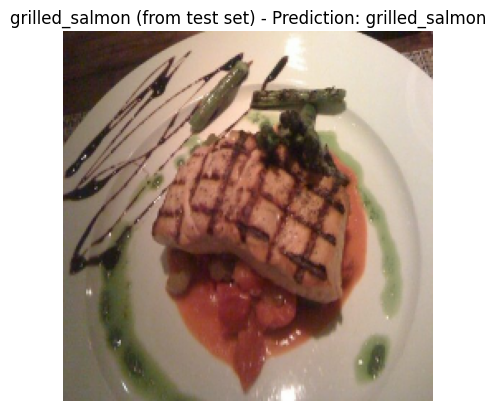

In [20]:
split_lab, split_ds = random.choice([("train", train_ds), ("val", val_ds), ("test", test_ds)])
for images, labels in split_ds.take(1):
  random_idx = random.choice(range(len(images)))
  random_image = images[random_idx]
  true_label = class_names[labels[random_idx].numpy().argmax()]
  pred_label = class_names[model_0_ultra_fine.predict(np.expand_dims(random_image, axis=0), verbose=0).argmax()]
  plt.imshow(random_image.numpy().astype("uint8"))
  plt.title(true_label + f" (from {split_lab} set) - Prediction: {pred_label}")
  plt.axis("off")